# ML-13 Project. Part I

Ниже приведено решение первой части проекта по прогнозированию временных рядов. В практике приведены конкретные шаги, которые необходимо выполнить для получения требуемого результата. Эти шаги указаны ниже по пунктам, после каждого пункта идёт код для его реализации.

Также дополнительно приведены собственные исследования и выводы.

**Формулировка задачи:** Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [44]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

from sklearn.model_selection import TimeSeriesSplit


In [45]:
from warnings import filterwarnings
filterwarnings("ignore")

## 1.1 Первоначальная загрузка и анализ данных

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [46]:
df = pd.read_csv('data/ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
df.rename(columns={'GDP (current US$)':'gdp'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Text(0.5, 1.0, 'Распределение ВВП африканской страны Гана')

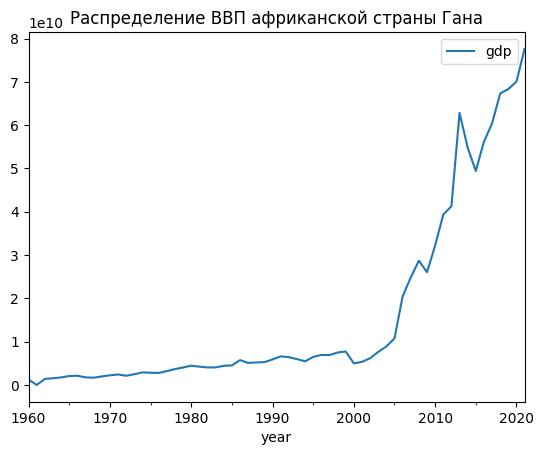

In [47]:
df.plot()
plt.title('Распределение ВВП африканской страны Гана')

**Первичные выводы:** на графике явно прослеживается общий тренд на увеличение. Причём до 2000 года повышение было малозаметным, после чего произошёл резкий скачок, провисший только в середине 10-х, во время мирового кризиса 14-15 года.

Сезонность на первый взгляд не видна.

Разложим ряд на тренд, сезонность и шум:

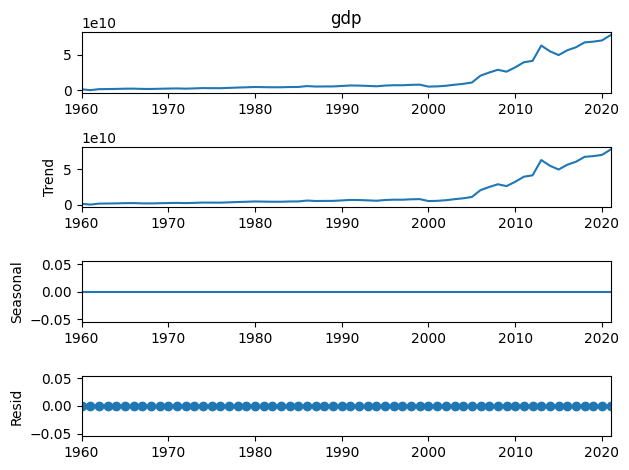

In [48]:
decompos = seasonal_decompose(df.gdp)
decompos.plot()
plt.show()

Как мы видим, наши первоначальные выводы оказались верны: тренд выделен, сезонности нет.

In [49]:
# разделяем выборку на тренировочную и тестовую
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
print(train_df.shape, test_df.shape)

(59, 1) (3, 1)


## 1.2 Построение модели скользящего среднего – MA

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

**Пример**: `train_df.spx.rolling(window=2).mean()`

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

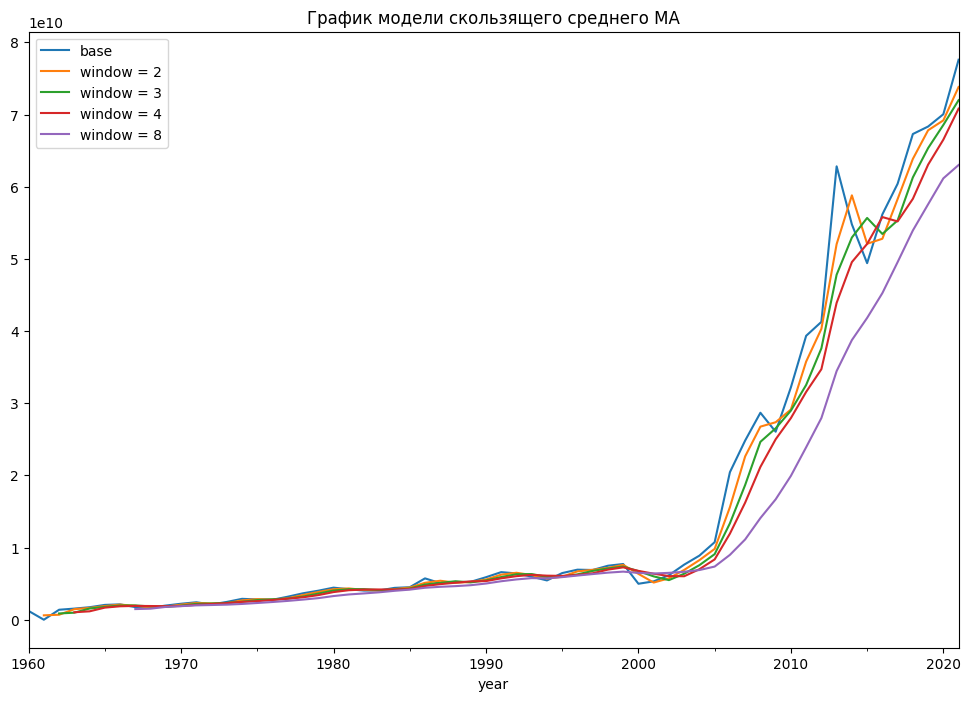

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df.plot(ax=ax)
df.gdp.rolling(window=2).mean().plot(ax=ax)
df.gdp.rolling(window=3).mean().plot(ax=ax)
df.gdp.rolling(window=4).mean().plot(ax=ax)
df.gdp.rolling(window=8).mean().plot(ax=ax)
ax.legend(['base', 'window = 2','window = 3', 'window = 4', 'window = 8'])
ax.set_title('График модели скользящего среднего MA')
plt.show()

**Выводы:** график скользящего среднего обычно используется для выявления и визуализации тренда. В нашем случае и распределение основного признака без преобразований отлично показывает тренд. Но график скользящего среднего с окном в 4-8 вполне дополняет наши первоначальные выводы.
Хотя окно более 4 уже скрывает просадки во время мировых финансовых кризисов. Поэтому в данном случае лучше использовать усреднение с окном не более 3.

## 1.3 Построение модели ARMA/ARIMA

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели `ARMA/ARIMA`.

> **Примечание:** Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры `p` и `q` выберите по коррелограммам `ACF` и `PACF`.

> **Примечание**: Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель `ARMA/ARIMA` для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент `AIC` (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

Для начала определим функцию, которая позволит нам узнать, является ли ряд стационарным.

In [51]:
def stat_test(df):
    """Определить, является ли входящий временной ряд стационарным

    Args:
        df (DataFrame): Dataframe с временным рядом на проверку стационарности тестом Дики-Фуллера
    """
    test = sm.tsa.adfuller(df.dropna())
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

Проверим наш ряд:

In [52]:
stat_test(train_df)

adf:  0.6529066974885374
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Ряд не является стационарным, необходимо его продифференцировать.

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


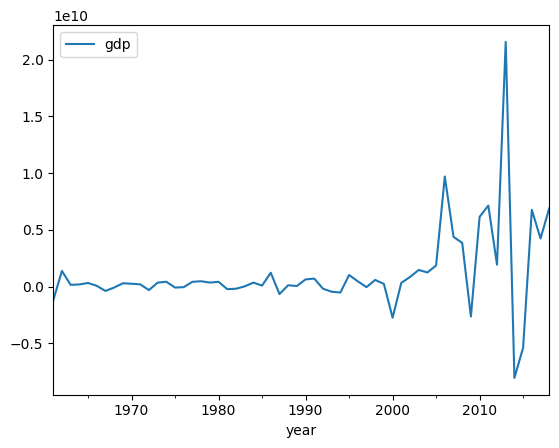

In [53]:
train_df_diff_1 = train_df.diff().dropna()
train_df_diff_1.plot()
stat_test(train_df_diff_1)

Ряд не стационарен, продолжаем дифферинцировать, пока не добьёмся стационарности:

adf:  -3.5836708658260332
p-value:  0.00608098975387688
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен


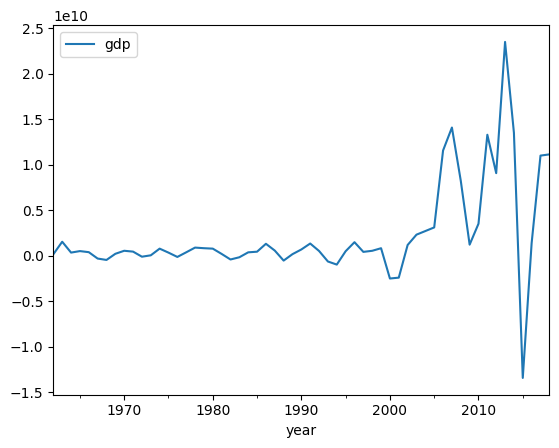

In [54]:
train_df_diff = train_df.diff(2).dropna()
train_df_diff.plot()
stat_test(train_df_diff)

In [55]:
# запоминаем порядок дифференциала
d = 2

Определим параметры `p` и `q` по коррелограммам `ACF` и `PACF`

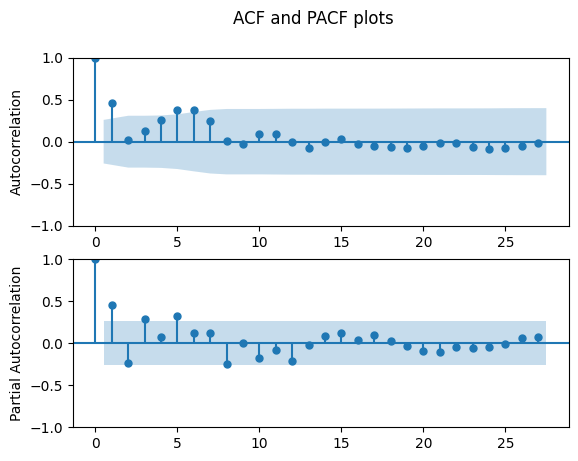

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1)
lags = 27
fig = sm.graphics.tsa.plot_acf(train_df_diff, lags=lags, ax=ax1)
ax1.set_ylabel('Autocorrelation')
ax1.set_title('')
# выбираем метод 'ywm', так как дефолтный метод 'yw' выводит коррелограмму за интервал [-1,1]
fig = sm.graphics.tsa.plot_pacf(train_df_diff, method='ywm', lags=lags, ax=ax2)
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('')
fig.suptitle('ACF and PACF plots')
plt.show()

Определяем параметры:
* `p` — параметр авторегрессионной модели `(AR(p))`
* `q` — параметр скользящего среднего `(MA(q))`

In [57]:
p = 1
q = 1

Построим модель `ARIMA` для прогнозирования поведения временного ряда. Выбираем ARIMA, т.к. первоначальный ряд не стационарный и нам пришлось его дефферинцировать. 

In [58]:
arima_model = ARIMA(train_df_diff, order=(p, d, q)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   57
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1316.107
Date:                Mon, 05 Jun 2023   AIC                           2638.214
Time:                        16:05:29   BIC                           2644.236
Sample:                    01-01-1962   HQIC                          2640.543
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0963        nan        nan        nan         nan         nan
ma.L1         -0.9756        nan        nan        nan         nan         nan
sigma2      5.169e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               331.81
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             304.35   Skew:                            -1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.46
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

У построенной модели коэффициент `AIC = 2638.214`

Попробуем построить несколько моделей с параметрами, ближайшими к найденным p и q. 

Для этого воспользуемся библиотекой `pmdarima` для подбора оптимальных гиперпараметров модели.

In [59]:
smodel = pm.auto_arima(
    train_df,
    d=d,
    start_p=1,
    start_q=1,
    max_p=10,
    max_q=10,
    seasonal=False,
    error_action="ignore",
    trace=True,
    n_jobs= -1
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 05 Jun 2023   AIC                           2680.765
Time:                        16:05:30   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682        nan        nan        nan         nan         nan
ma.L1         -0.4241        nan        nan        nan         nan         nan
ma.L2         -0.8256        nan        nan        nan         nan         nan
ma.L3          0.5193        nan        nan        nan         nan         nan
sigma2      1.868e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Попробуем построить модель с предложенными параметрами

In [60]:
arima_model_pm = ARIMA(train_df, order=(1, 2, 3)).fit()
arima_model_pm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 05 Jun 2023   AIC                           2680.765
Time:                        16:05:30   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682        nan        nan        nan         nan         nan
ma.L1         -0.4241        nan        nan        nan         nan         nan
ma.L2         -0.8256        nan        nan        nan         nan         nan
ma.L3          0.5193        nan        nan        nan         nan         nan
sigma2      1.868e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

**Выводы:** В итоге видим, что библиотека `pmdarima` выдала результаты хуже, чем ручной подбор параметров. Возможно я что-то не так настроил, но пока никак не могу заставить библиотеку просчитать все параметры, а не останавливаться на середине.

Главный вывод: на библиотеки надейся, но сам всё перепроверяй!

Раз не получилось воспользоваться библиотекой, то организуем подбор параметров самостоятельно.

In [61]:
def select_hyperparam(data, d, p_min=0, p_max=10, q_min=0, q_max=10):
    """Определяет лучшие гиперпараметры модели ARIMA

    Args:
        data (DataFrame): временной ряд
        d (int): порядок дифференцирования
        p_min (int, optional): Минимальный порог p. Defaults to 0.
        p_max (int, optional): Максимальный порог p. Defaults to 10.
        q_min (int, optional): Минимальный порог q. Defaults to 0.
        q_max (int, optional): Максимальный порог q. Defaults to 10.

    Returns:
        ARIMAResultsWrapper: модель с лучшими гиперпараметрами
    """
    p_test_strange, q_test_strange = p_min, q_min
    aic_test_strange = 99999.00
    result_model = None

    for i in range(p_min, p_max+1):
        for j in range(q_min, q_max+1):
            arima_model_test = ARIMA(data, order=(i, d, j)).fit()
            # print(f'({i}, {d}, {j}). AIC = {arima_model_test.aic}')
            if arima_model_test.aic < aic_test_strange:
                aic_test_strange = arima_model_test.aic
                p_test_strange = i
                q_test_strange = j
                result_model = arima_model_test

    print(p_test_strange, q_test_strange, aic_test_strange)
    return result_model

In [62]:
result_model = select_hyperparam(train_df, d)

7 0 2668.0363975268906


Смотрим на результаты получившейся модели:

In [63]:
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(7, 2, 0)   Log Likelihood               -1326.018
Date:                Mon, 05 Jun 2023   AIC                           2668.036
Time:                        16:05:50   BIC                           2684.381
Sample:                    01-01-1960   HQIC                          2674.388
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0128        nan        nan        nan         nan         nan
ar.L2         -1.0938        nan        nan        nan         nan         nan
ar.L3         -0.7783        nan        nan        nan         nan         nan
ar.L4         -0.8827        nan        nan        nan         nan         nan
ar.L5         -0.4933        nan        nan        nan         nan         nan
ar.L6         -0.2029        nan        nan        nan         nan         nan
ar.L7          0.4266        nan        nan        nan         nan         nan
sigma2      7.716e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               101.89
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              73.60   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Построим предсказание и сравним с тестовой выборкой.

Для этого подготовим DataFrame с исходными и предсказанными данными:

In [64]:
pred_df = pd.DataFrame(index=df.index)
pred_df['gdp'] = df['gdp']

pred_df['model_preds'] = result_model.predict(
    start=train_df.index[1], end=test_df.index[-1]
)

forecast_df = result_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)
pred_df.at[test_df.index, 'model_pred_lower'] = forecast_df['lower gdp']
pred_df.at[test_df.index, 'model_pred_upper'] = forecast_df['upper gdp']

pred_df.tail()

,gdp,model_preds,model_pred_lower,model_pred_upper
year,,,,
2017-01-01,6.040638e+10,5.954711e+10,NaN,NaN
2018-01-01,6.729928e+10,6.977295e+10,NaN,NaN
2019-01-01,6.833754e+10,7.086150e+10,6.541715e+10,7.630584e+10
2020-01-01,7.004320e+10,7.920296e+10,7.155281e+10,8.685312e+10
2021-01-01,7.759428e+10,6.735318e+10,5.824966e+10,7.645670e+10


Построим графики:

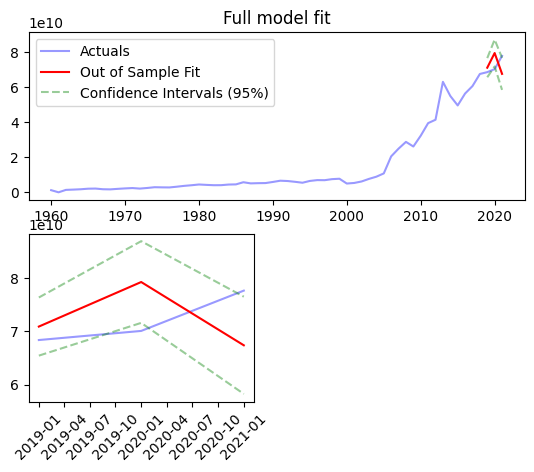

In [65]:
# график со всем рядом
plt.subplot(211)
plt.plot(pred_df['gdp'], color='blue', label='Actuals', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_preds'], color='red', linestyle='-', label='Out of Sample Fit')
plt.plot(pred_df.loc[test_df.index]['model_pred_lower'], color='green', linestyle='--', label='Confidence Intervals (95%)', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_pred_upper'], color='green', linestyle='--', alpha=.4)
plt.title('Full model fit')
plt.legend()

# график с приближением предсказанных значений
plt.subplot(223)
plt.plot(pred_df.loc[test_df.index]['gdp'], color='blue', label='Actuals', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_preds'], color='red', linestyle='-', label='Out of Sample Fit')
plt.plot(pred_df.loc[test_df.index]['model_pred_lower'], color='green', linestyle='--', label='Confidence Intervals (95%)', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_pred_upper'], color='green', linestyle='--', alpha=.4)
plt.xticks(rotation=45)

plt.show()


## 1.6 Выводы по полученным результатам

Предсказание нашей модели получилось близким к реальности. Но модель не правильно уловила тренд, её предсказания идут вниз, тогда как реальные даные идут вверх. Это может быть критичней близости к точным значениям!

## 2.1 Проверка данных на наличие пропущенных дат

Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода `DataFrame.asfreq()`, передав в него параметр частоты, например `‘d’` — день, `‘m’` — месяц. Все алиасы для параметров частоты доступны по ссылке:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases 

<Axes: xlabel='year'>

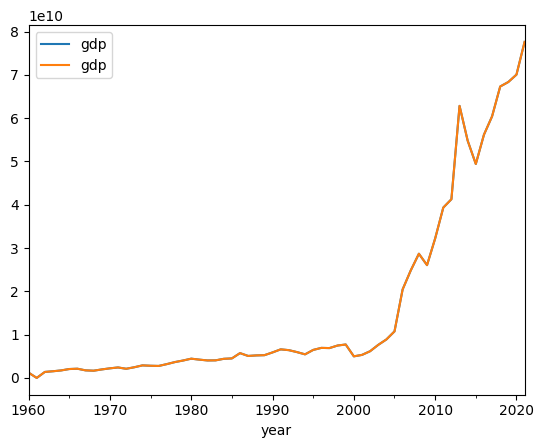

In [66]:
ax = df.asfreq(freq='AS').plot()
df.plot(ax=ax)

По графку видно, что дата попадает в ноль только в самом начале, далее график растёт вверх.

Найдём это значение.

In [67]:
df[df['gdp'] == 0]
# df

,gdp
year,
1961-01-01,0.0


## 2.2 Проверка на наличие пропусков

In [68]:
df['gdp'].isna().sum()

0

Отлично! Пропусков нет.

## 2.3 Обрабатываем нули

Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`.

Создадим копию данных, чтобы всегда можно было вернуться к предыдущим данным.

In [69]:
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x == 0 else x)
df[df['gdp'] == 0]

,gdp
year,


Все нули заменили на пропуски. Можем корректно их заполнить.

## 2.4 Заполняем пропуски

Для заполнения пропусков выполните интерполяцию с использованием метода `.interpolate()`

In [70]:
df['gdp'].interpolate(method='linear', inplace=True)
df.head()

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Наш единственный пропуск заполнен.

In [71]:
# после заполнения пропусков заново разделяем выборку на тренировочную и тестовую
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
print(train_df.shape, test_df.shape)

(59, 1) (3, 1)


## 2.5 Строим модель

Проверьте полученный ряд на стационарность, определите параметры модели (`ARIMA/ARMA`) и запустите модель.

In [72]:
stat_test(train_df)

adf:  0.8030073326980108
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


adf:  -3.999803440949154
p-value:  0.0014115408436661007
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен


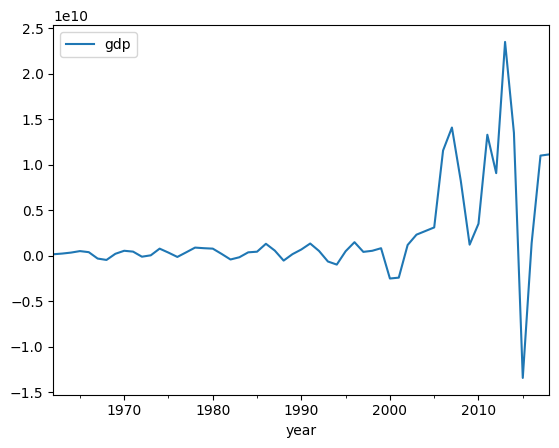

In [73]:
train_df_diff = train_df.diff(2).dropna()
train_df_diff.plot()
stat_test(train_df_diff)

Порядок дифференцирования не изменился

In [74]:
d = 2

Определим лучшие гиперпараметры новой модели:

In [75]:
result_model_fillna = select_hyperparam(train_df, d)
result_model_fillna.summary()

6 1 2667.874003852907


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(6, 2, 1)   Log Likelihood               -1325.937
Date:                Mon, 05 Jun 2023   AIC                           2667.874
Time:                        16:06:10   BIC                           2684.218
Sample:                    01-01-1960   HQIC                          2674.226
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7403        nan        nan        nan         nan         nan
ar.L2         -1.9018        nan        nan        nan         nan         nan
ar.L3         -1.6995        nan        nan        nan         nan         nan
ar.L4         -1.6118        nan        nan        nan         nan         nan
ar.L5         -1.2341        nan        nan        nan         nan         nan
ar.L6         -0.7012        nan        nan        nan         nan         nan
ma.L1          0.9109        nan        nan        nan         nan         nan
sigma2      1.076e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                84.60
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):             203.42   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Сравним метрики моделей, построенных на данных с пропусками и без:

In [76]:
print(f'AIC model on data with 0 and NaN = {result_model.aic}')
print(f'AIC model on data without 0 and NaN = {result_model_fillna.aic}')

AIC model on data with 0 and NaN = 2668.0363975268906
AIC model on data without 0 and NaN = 2667.874003852907


## 2.6 Выводы

Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

Видим, что даже заполнение единственного пропуска привело к улучшению метрики. 

Вывод: всегда необходимо тщательно проверять и подготавливать данные.

### Задание 8.3

1. Разбейте временной ряд на три набора `(3 train + 3 test)`. Для этого воспользуйтесь классом `TimeSeriesSplit` из `sklearn.model_selection` с параметрами `n_splits=3` и `test_size=7` (или `max_train_size=df.sales.count()-7`). Наборы данных можно получить, вызвав метод `split` (временной ряд) у инициализированного `TimeSeriesSplit`.

2. Выведите размеры полученных подвыборок

Обратите внимание на отличие в размерах выборок на рисунке с `walk forward validation` и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [77]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df.gdp)
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


## 3 Волатильность

**Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

В скринкасте мы получаем предсказания с помощью `model_results.forecast()`.

Любое обращение к методу `forecast()` возвращает объект `ARCHModelForecast` с тремя основными атрибутами:

* `.mean`— условное среднее значение ряда
* `.variance` — условная дисперсия прогноза
* `.residual_variance` — прогнозируемая условная дисперсия остатков

`Residual_variance` будет отличаться от variance в случаях, когда значения ряда (не дисперсии, а именно сами значения) имеют зависимость от себя в прошлом. В скринкасте для предсказания дисперсии мы используем `residual_variance`, так как в нашем случае ряд стационарен и `residual_variance` и `variance` возвращают одинаковые значения.

## 3.1 Посчитайте волатильность для вашего временного ряда

Посчитаем волатильность временного ряда

In [83]:
df['gdp_vol'] = df.gdp.pct_change(1).mul(100).abs()
train_df.head()

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Отобразим волатильность на графике

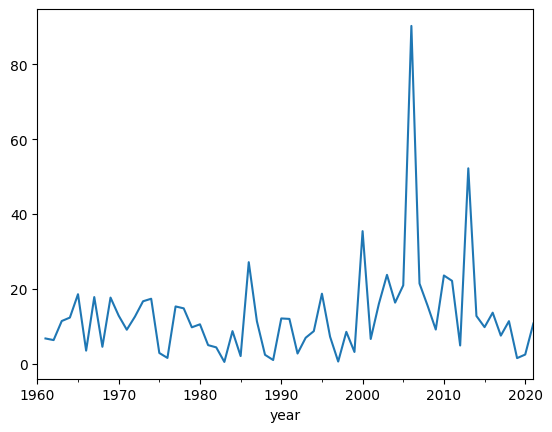

In [84]:
df['gdp_vol'].plot()
plt.show()

## 3.2 Используйте GARCH-модель для предсказания волатильности

Т.к. у нас в Dataframe добавился новый признак, то заново проведём разделение на тренировочную и тестовую выборки

In [85]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
print(train_df.shape, test_df.shape)

(59, 2) (3, 2)


Определим параметры `p` и `q` по коррелограммам `ACF` и `PACF`

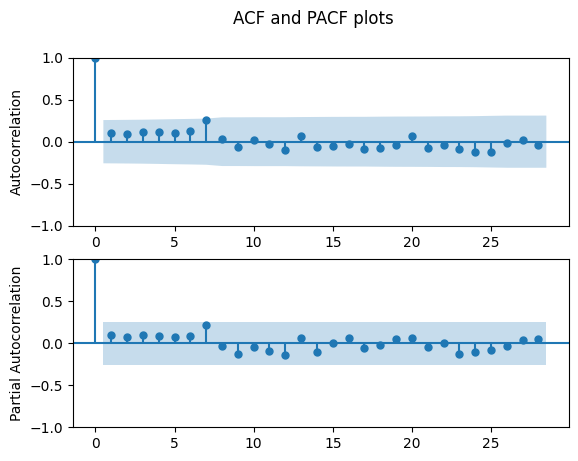

In [94]:
fig, (ax1, ax2) = plt.subplots(2, 1)
lags = 28
fig = sm.graphics.tsa.plot_acf(train_df.gdp_vol[1:], lags=lags, ax=ax1)
ax1.set_ylabel('Autocorrelation')
ax1.set_title('')
# выбираем метод 'ywm', так как дефолтный метод 'yw' выводит коррелограмму за интервал [-1,1]
fig = sm.graphics.tsa.plot_pacf(train_df.gdp_vol[1:], method='ywm', lags=lags, ax=ax2)
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('')
fig.suptitle('ACF and PACF plots')
plt.show()

Новой информации нет, поэтому параметры `p` и `q` выбираем равными единице.

In [96]:
p, q = 1, 1

Проведём тест Дики-Фуллера для определения является ли ряд стационарным.

In [97]:
stat_test(train_df.gdp_vol[1:])

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


Ряд стационарен, никаких преобразований для обучения модели не потребуется.

Построим модель `GARCH(1, 1)`